In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("bigdata_gc.csv")

print(df.shape)
print(df.head())

(38252, 70)
    datadate   CAPEI     bm     evm  pe_exi   pe_inc     ps     pcf    dpr  \
0  31MAY2015  22.242  0.908  14.342 -19.250  112.292  0.598 -22.165  0.000   
1  31MAY2018  45.050  0.614  13.665  22.469  115.634  0.942  25.615  0.141   
2  31MAY2016  23.079  1.068   7.236  20.828   17.635  0.504  26.116  0.260   
3  31MAY2014  16.991  1.208   6.232  14.699   14.699  0.523   7.618  0.165   
4  31MAY2017  39.197  0.793   9.161  25.793   22.805  0.728  59.011  0.205   

     npm  ...  sale_nwc  rd_sale  adv_sale  staff_sale  accrual    ptb  \
0 -0.034  ...     2.941      0.0       0.0         0.0   -0.006  1.004   
1  0.042  ...     2.869      0.0       0.0         0.0    0.006  1.730   
2  0.024  ...     3.056      0.0       0.0         0.0    0.006  0.931   
3  0.036  ...     2.847      0.0       0.0         0.0   -0.031  0.917   
4  0.028  ...     3.194      0.0       0.0         0.0    0.019  1.352   

   PEG_trailing  fyear  gc  cid  
0         0.000   2015   0    1  
1     

In [3]:
print("Total missing values:", df.isnull().sum().sum())

Total missing values: 13268


In [4]:
missing_cols = df.isnull().sum()
missing_cols[missing_cols > 0].sort_values(ascending=False)


cash_ratio    6634
curr_ratio    6634
dtype: int64

In [5]:
#As there is no separation by industry in the dataset provided, I decided to use prior year and same CID data to impute
#This allows comparability as different company types in the real world have different characteristics.

df = df.sort_values(by=['cid', 'fyear'])

df['cash_ratio'] = df.groupby('cid')['cash_ratio'].transform(lambda x: x.ffill())
df['curr_ratio'] = df.groupby('cid')['curr_ratio'].transform(lambda x: x.ffill())

print("Remaining NAs in cash_ratio:", df['cash_ratio'].isnull().sum())
print("Remaining NAs in curr_ratio:", df['curr_ratio'].isnull().sum())

Remaining NAs in cash_ratio: 6546
Remaining NAs in curr_ratio: 6546


In [6]:
#For the missing values, I created a new column to indicate that they are in fact missing. 
#Reason is the missing values might be linked to whether a company has gc issues

df['cash_ratio_missing'] = df['cash_ratio'].isnull().astype(int)
df['curr_ratio_missing'] = df['curr_ratio'].isnull().astype(int)


Selected Top 15 Features: ['pe_exi', 'pe_inc', 'pcf', 'roa', 'pretret_earnat', 'GProf', 'equity_invcap', 'rect_act', 'debt_at', 'short_debt', 'curr_debt', 'lt_debt', 'ocf_lct', 'debt_assets', 'at_turn']

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     10929
           1       0.24      0.84      0.37       547

    accuracy                           0.86     11476
   macro avg       0.61      0.85      0.64     11476
weighted avg       0.95      0.86      0.90     11476


Feature Coefficients (Most Influential):
           Feature  Coefficient
3              roa    -1.626850
4   pretret_earnat    -0.884804
12         ocf_lct    -0.669774
8          debt_at     0.562783
10       curr_debt     0.471628
9       short_debt     0.443927
13     debt_assets     0.294999
2              pcf    -0.269642
14         at_turn    -0.261154
11         lt_debt    -0.177648
1           pe_inc    -0.154537
0           pe_exi  

<Figure size 600x500 with 0 Axes>

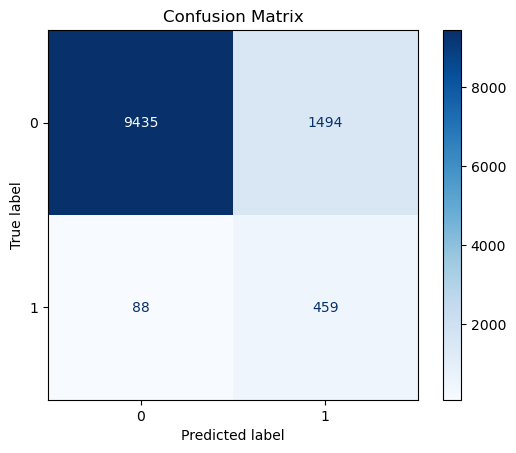

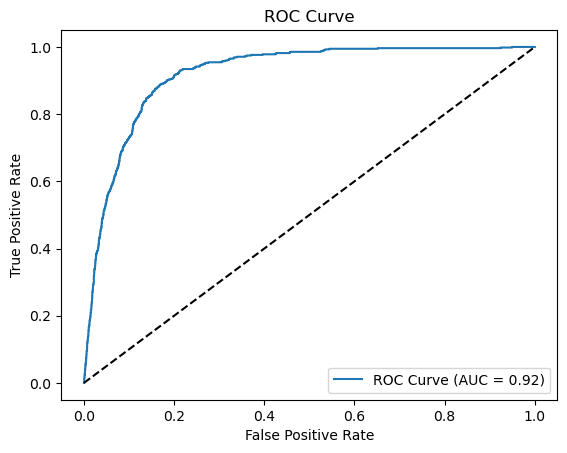

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_csv("bigdata_gc.csv")

# 2. Separate features and target
X = df.drop(columns=['gc'])  # All columns except target
y = df['gc']

# 3. Drop identifiers that shouldn't be used as features
X = X.drop(columns=['datadate', 'cid', 'fyear'])

# 4. Train-test split (stratified to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 5. Impute missing values using median (only fit on train)
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

imputer = SimpleImputer(strategy='median')
X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

X_train_imputed[numeric_cols] = imputer.fit_transform(X_train[numeric_cols])
X_test_imputed[numeric_cols] = imputer.transform(X_test[numeric_cols])

# 6. Feature selection: Select top 15 most relevant features using statistical method
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train_imputed, y_train)

top_15_features = X_train.columns[selector.get_support()].tolist()
print("Selected Top 15 Features:", top_15_features)

X_train_selected = X_train_imputed[top_15_features]
X_test_selected = X_test_imputed[top_15_features]

# 7. Scale features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# 8. Train logistic regression with class weight balancing
model = LogisticRegression(class_weight='balanced', max_iter=2000)
model.fit(X_train_scaled, y_train)

# 9. Predict and evaluate
y_pred = model.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 10. Interpret coefficients
coefficients = pd.DataFrame({
    'Feature': top_15_features,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nFeature Coefficients (Most Influential):")
print(coefficients)

# 11. Optional: Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# 12. Optional: ROC Curve
try:
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
except AttributeError:
    print("Model does not support probability estimates.")

Selected Top 15 Features: ['pe_exi', 'pe_inc', 'pcf', 'roa', 'pretret_earnat', 'GProf', 'equity_invcap', 'rect_act', 'debt_at', 'short_debt', 'curr_debt', 'lt_debt', 'ocf_lct', 'debt_assets', 'at_turn']


C:\Users\VENANSIUS N WIDODO\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:25:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     10929
           1       0.34      0.64      0.45       547

    accuracy                           0.93     11476
   macro avg       0.66      0.79      0.70     11476
weighted avg       0.95      0.93      0.94     11476


Confusion Matrix:


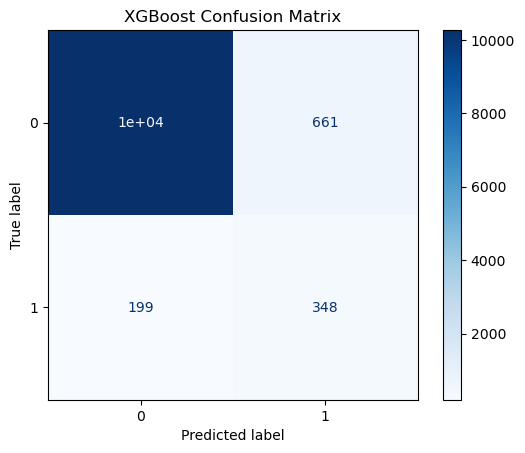


Feature Importance:


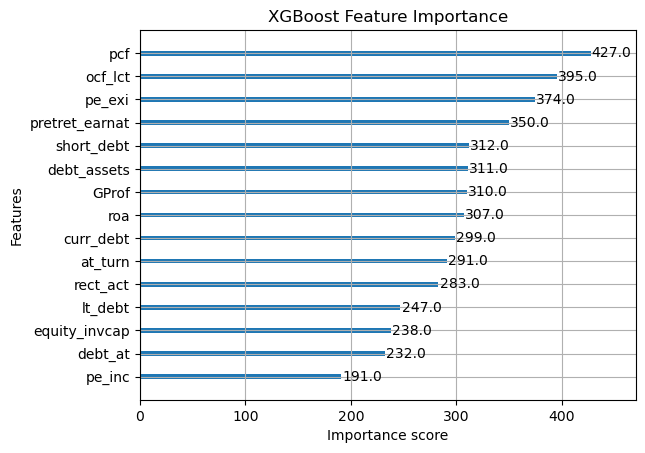

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Load dataset
df = pd.read_csv("bigdata_gc.csv")

# 2. Separate features and target
X = df.drop(columns=['gc'])  # All columns except 'gc'
y = df['gc']

# 3. Drop irrelevant identifiers
X = X.drop(columns=['datadate', 'cid', 'fyear'])

# 4. Train-test split (stratified to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 5. Impute missing values only on training data
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

imputer = SimpleImputer(strategy='median')
X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

X_train_imputed[numeric_cols] = imputer.fit_transform(X_train[numeric_cols])
X_test_imputed[numeric_cols] = imputer.transform(X_test[numeric_cols])

# 6. Feature selection: Select top 15 most statistically significant features
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train_imputed, y_train)

top_15_features = X.columns[selector.get_support()].tolist()
print("Selected Top 15 Features:", top_15_features)

X_train_selected = X_train_imputed[top_15_features]
X_test_selected = X_test_imputed[top_15_features]

# 7. Apply SMOTE to oversample minority class in training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_selected, y_train)

# 8. Train XGBoost classifier
xgb_model = XGBClassifier(
    scale_pos_weight=(y_resampled.value_counts()[0] / y_resampled.value_counts()[1]),
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_resampled, y_resampled)

# 9. Predict and evaluate
y_pred = xgb_model.predict(X_test_selected)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 10. Optional: Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("XGBoost Confusion Matrix")
plt.show()

# 11. Optional: Feature Importance Plot
print("\nFeature Importance:")
from xgboost import plot_importance
plot_importance(xgb_model)
plt.title("XGBoost Feature Importance")
plt.show()



In [9]:

import matplotlib.pyplot as plt  # Required for visualizations
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix

# --- 1. Load dataset ---
df = pd.read_csv("bigdata_gc.csv")

# --- 2. Separate features and target ---
X = df.drop(columns=['gc'])  # All columns except 'gc'
y = df['gc']

# --- 3. Drop irrelevant identifiers ---
X = X.drop(columns=['datadate', 'cid', 'fyear'])

# --- 4. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 5. Impute missing values ---
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='median')

X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

X_train_imputed[numeric_cols] = imputer.fit_transform(X_train[numeric_cols])
X_test_imputed[numeric_cols] = imputer.transform(X_test[numeric_cols])

# --- 6. Feature selection ---
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train_imputed, y_train)

top_15_features = X.columns[selector.get_support()].tolist()
print("Selected Top 15 Features:", top_15_features)

X_train_selected = X_train_imputed[top_15_features]
X_test_selected = X_test_imputed[top_15_features]

# --- 7. Apply SMOTE ---
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_selected, y_train)

# --- 8. Train XGBoost classifier ---
xgb_model = XGBClassifier(
    scale_pos_weight=(y_resampled.value_counts()[0] / y_resampled.value_counts()[1]),
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_resampled, y_resampled)

# --- 9. Predict probabilities ---
y_proba = xgb_model.predict_proba(X_test_selected)[:, 1]

# --- 10. Threshold tuning ---
thresholds = np.linspace(0.01, 0.5, 50)
recall_scores = []
precision_scores = []
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    recall = recall_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)

best_recall_idx = np.argmax(recall_scores)
best_threshold_recall = thresholds[best_recall_idx]
best_f1_idx = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_f1_idx]

# --- 11. Predict using optimal thresholds ---
y_pred_default = (y_proba >= 0.5).astype(int)
y_pred_recall = (y_proba >= best_threshold_recall).astype(int)
y_pred_f1 = (y_proba >= best_threshold_f1).astype(int)

# --- 12. Print Reports ---
def print_cm(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n--- {title} ---")
    print(f"TN: {tn} | FP: {fp}")
    print(f"FN: {fn} | TP: {tp}")

print("\n--- Classification Report (Default Threshold 0.5) ---")
print(classification_report(y_test, y_pred_default))

print("\n--- Classification Report (Max Recall Threshold) ---")
print(classification_report(y_test, y_pred_recall))

print("\n--- Classification Report (Best F1 Threshold) ---")
print(classification_report(y_test, y_pred_f1))

print_cm(y_test, y_pred_default, "Threshold = 0.5")
print_cm(y_test, y_pred_recall, f"Threshold = {best_threshold_recall:.3f} (Max Recall)")
print_cm(y_test, y_pred_f1, f"Threshold = {best_threshold_f1:.3f} (Best F1)")



Selected Top 15 Features: ['pe_exi', 'pe_inc', 'pcf', 'roa', 'pretret_earnat', 'GProf', 'equity_invcap', 'rect_act', 'debt_at', 'short_debt', 'curr_debt', 'lt_debt', 'ocf_lct', 'debt_assets', 'at_turn']


C:\Users\VENANSIUS N WIDODO\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:25:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Classification Report (Default Threshold 0.5) ---
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     10929
           1       0.34      0.64      0.45       547

    accuracy                           0.93     11476
   macro avg       0.66      0.79      0.70     11476
weighted avg       0.95      0.93      0.94     11476


--- Classification Report (Max Recall Threshold) ---
              precision    recall  f1-score   support

           0       1.00      0.76      0.87     10929
           1       0.17      0.96      0.29       547

    accuracy                           0.77     11476
   macro avg       0.58      0.86      0.58     11476
weighted avg       0.96      0.77      0.84     11476


--- Classification Report (Best F1 Threshold) ---
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     10929
           1       0.34      0.64      0.45       547

    accuracy          

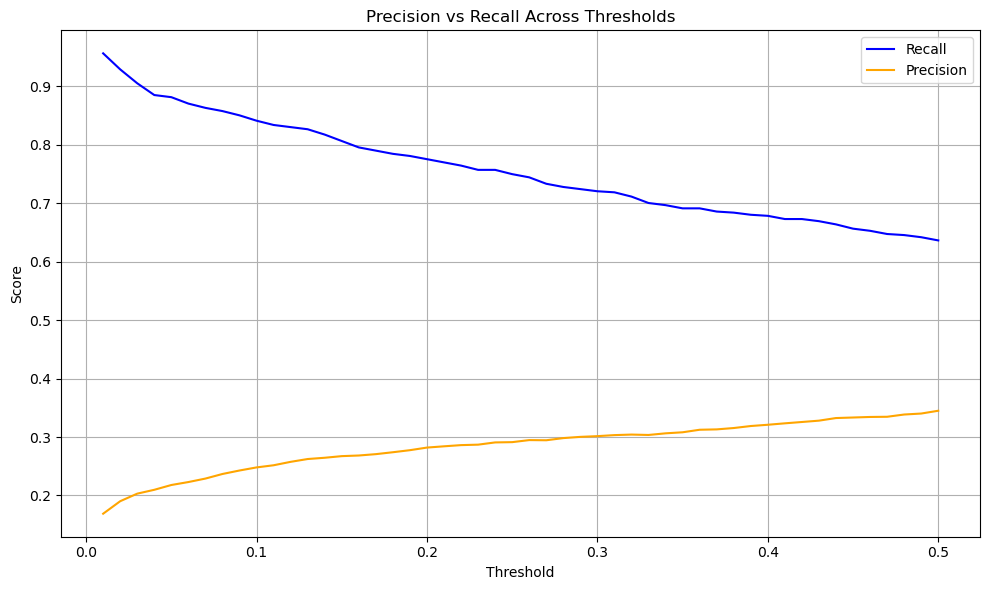

<Figure size 1000x800 with 0 Axes>

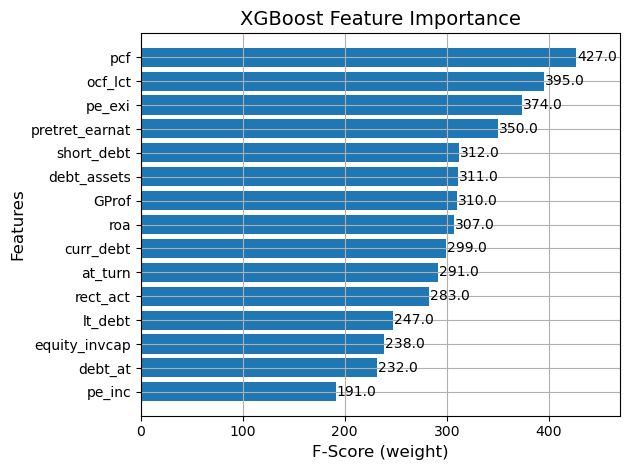

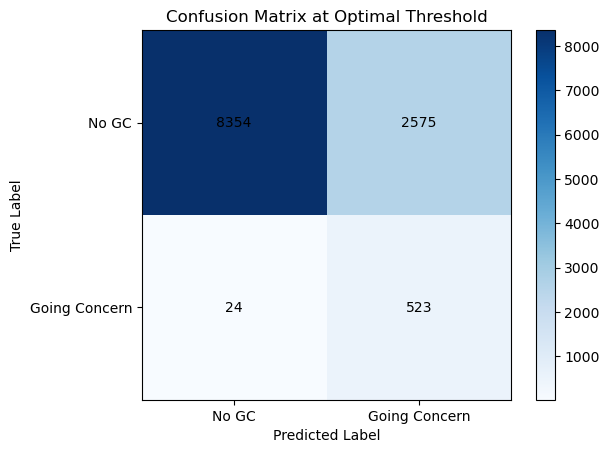

In [10]:
# --- VISUALIZATION CODE ---

# 1. Precision vs Recall vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall_scores, label='Recall', color='blue')
plt.plot(thresholds, precision_scores, label='Precision', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall Across Thresholds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Feature Importance Plot
from xgboost import plot_importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=15, height=0.8)
plt.title("XGBoost Feature Importance", fontsize=14)
plt.xlabel("F-Score (weight)", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

# 3. Confusion Matrix at Max Recall Threshold
cm = confusion_matrix(y_test, y_pred_recall)
disp = plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar(disp)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['No GC', 'Going Concern'])
plt.yticks([0, 1], ['No GC', 'Going Concern'])
plt.title("Confusion Matrix at Optimal Threshold")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')
plt.show()